<a href="https://colab.research.google.com/github/harikrishnareddymallavarapu/Masters/blob/main/Masters_Deep2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import spacy
import torch


In [3]:
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):

  def __init__(self, review_df, vectorizer):
    self.review_df = review_df
    self._vectorizer = vectorizer
    self.xTrain = self._vectorizer.fit_transform(review_df.text.to_list())
    self.vocabSize = len(self.xTrain.toarray()[0])


  def get_vectorizer(self):
    """ returns the vectorizer """
    return self._vectorizer

  def __len__(self):
    return self.review_df.shape[0]
  
  def __getitem__(self, index):

    review_vector = self.xTrain[index].toarray()[0]
    rating_index = self.review_df.topicsList.loc[index]
    return {'x_data': torch.Tensor(review_vector),'y_target': torch.Tensor(rating_index)}


In [4]:
class Vocabulary(object):
  def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
    if token_to_idx is None:
      token_to_idx = {}
    self._token_to_idx = token_to_idx
    self._idx_to_token = {idx: token for token, idx in self._token_to_idx.items()}
    self._add_unk = add_unk
    self._unk_token = unk_token
    self.unk_index= 1
    if add_unk:
      self.unk_index = self.add_token(unk_token)

  def to_serializable(self):
    return {'token_to_idx': self._token_to_idx,'add_unk': self._add_unk,'unk_token': self._unk_token}

  def lookup_token(self, token):
    if self.add_unk:
      return self._token_to_idx.get(token, self.unk_index)
    else:
      return self._token_to_idx[token]

  def lookup_index(self, index):

    if index not in self._idx_to_token:
      raise KeyError("the index (%d) is not in the Vocabulary" % index)
    return self._idx_to_token[index]

  def __len__(self):
    return len(self._token_to_idx)


In [5]:
class ReviewVectorizer(object):

  def __init__(self, review_vocab, rating_vocab):
    self.review_vocab = review_vocab
    self.rating_vocab = rating_vocab

  def vectorize(self, review):
    one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
    for token in review.split(" "):
      if token not in string.punctuation:
        one_hot[self.review_vocab.lookup_token(token)] = 1
    return one_hot




In [6]:
import pickle

pkl_file = open('drive/My Drive/Top-Ex/article_topic_2.pkl', 'rb')
article_topic = pickle.load(pkl_file)
pkl_file.close()

In [7]:
article_topic.head()

,title,content,Topic_01,Topic_02,Topic_03,Topic_04,Topic_05,Topic_06,Topic_07,Topic_08,Topic_09,Topic_10,Topic_11,lemmatized,text
0,Trump says his ’massive’ tax plan is coming ne...,’ ’ ’ President Donald Trump said that he e...,0.290998,0.010906,0.450176,0.005970,0.061371,0.014272,0.008211,0.055154,0.005457,0.092393,0.005092,"[say, massive, tax, plan, come, next, week, pr...",say massive tax plan come next week president ...
1,Chicago police have ’no regard’ for minority l...,Police in Chicago have ”no regard for the san...,0.058792,0.002780,0.009205,0.431409,0.001869,0.102680,0.018864,0.058535,0.009905,0.275659,0.030303,"[regard, minority, live, say, life, come, peop...",regard minority live say life come people colo...
2,A Concussion Can Lead To Sleep Problems That L...,People who sustain a concussion or a more seve...,0.020495,0.157279,0.050228,0.017358,0.015984,0.086818,0.002245,0.043450,0.002179,0.010960,0.593004,"[concussion, lead, sleep, problem, last, year,...",concussion lead sleep problem last year people...
3,Trump: I Was Just Joking When I Made Crude Co...,’You can watch the interview here:’] Trump’s c...,0.174913,0.012685,0.036574,0.041777,0.010217,0.084963,0.197679,0.412116,0.005444,0.018977,0.004655,"[joking, make, crude, comment, woman, watch, i...",joking make crude comment woman watch intervie...
4,"Beyoncé Dropped Out Of Coachella, Because Duh","’ It has happened, friends: Beyoncé has offici...",0.028872,0.145885,0.064897,0.074325,0.158659,0.171485,0.006119,0.210629,0.004514,0.019160,0.115456,"[drop, coachella, happen, friend, officially, ...",drop coachella happen friend officially cancel...


In [8]:
article_topic = article_topic[['text', 'Topic_01', 'Topic_02', 'Topic_03', 'Topic_04',
       'Topic_05', 'Topic_06', 'Topic_07', 'Topic_08', 'Topic_09', 'Topic_10',
       'Topic_11']]

In [9]:
article_topic['topicsList'] = 0
article_topic['topicsList'] = article_topic['topicsList'].astype(object)
for i in range(article_topic.shape[0]):
  article_topic['topicsList'].loc[i] = [article_topic['Topic_01'].loc[i],article_topic['Topic_02'].loc[i], article_topic['Topic_03'].loc[i],article_topic['Topic_04'].loc[i],article_topic['Topic_05'].loc[i],
                                        article_topic['Topic_06'].loc[i],article_topic['Topic_07'].loc[i], article_topic['Topic_08'].loc[i],article_topic['Topic_09'].loc[i],article_topic['Topic_10'].loc[i],article_topic['Topic_11'].loc[i]]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [10]:
article_topic= article_topic[['text','topicsList']]
article_topic.head(5)

,text,topicsList
0,say massive tax plan come next week president ...,"[0.29099777, 0.010906174, 0.45017645, 0.005970..."
1,regard minority live say life come people colo...,"[0.058792174, 0.0027798961, 0.009204507, 0.431..."
2,concussion lead sleep problem last year people...,"[0.020495262, 0.15727887, 0.050227765, 0.01735..."
3,joking make crude comment woman watch intervie...,"[0.17491275, 0.012685176, 0.036573526, 0.04177..."
4,drop coachella happen friend officially cancel...,"[0.028872162, 0.14588493, 0.06489669, 0.074324..."


In [47]:
import pickle


# filehandler = open("drive/My Drive/Top-Ex/article_topic_deep.pkl","wb")
# pickle.dump(article_topic,filehandler)
# filehandler.close()

In [11]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
# import shap

In [12]:
vectorizer = CountVectorizer(min_df=10)

In [50]:
# dataset = NewsDataset(article_topic, vectorizer)
# dataset

In [51]:
del article_topic
# dataset[2]

In [52]:
# dataLoader = DataLoader(dataset, batch_size=3)

In [53]:
# del dataset

In [54]:
# i=0
# for batch in dataLoader:
#   print(batch)
#   i=i+1
#   if i==2:
#     break

In [13]:
from torch import nn
import torch.nn.functional as F

class TopicModel(nn.Module):

    def __init__(self, vocab_size, input_dim,hidden_dims, num_class):
        super(TopicModel, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, num_class)

    def forward(self, text):
        out1= self.fc1(text)
        out1 = F.relu(out1)
        out2 = self.fc2(out1)
        return F.softmax(out2)

In [56]:
 import pickle

#  pkl_file = open('drive/My Drive/Top-Ex/article_topic_deep.pkl', 'rb')
#  article_topic = pickle.load(pkl_file)
#  pkl_file.close()


In [57]:
article_topic.head()

,text,topicsList
0,say massive tax plan come next week president ...,"[0.29099777, 0.010906174, 0.45017645, 0.005970..."
1,regard minority live say life come people colo...,"[0.058792174, 0.0027798961, 0.009204507, 0.431..."
2,concussion lead sleep problem last year people...,"[0.020495262, 0.15727887, 0.050227765, 0.01735..."
3,joking make crude comment woman watch intervie...,"[0.17491275, 0.012685176, 0.036573526, 0.04177..."
4,drop coachella happen friend officially cancel...,"[0.028872162, 0.14588493, 0.06489669, 0.074324..."


In [14]:
dataset = NewsDataset(article_topic, vectorizer)
del article_topic

In [15]:
emsize = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TopicModel(dataset.vocabSize, emsize, num_class=11, hidden_dims=100).to(device)

In [16]:
import torch.optim as optim

In [17]:
# for idx, batch in enumerate(dataLoader):
#   print(batch['x_data'], batch['y_target'].shape)
#   break

In [39]:
learning_rate = 1e-6
epochs = 200

criterion = torch.nn.CosineEmbeddingLoss(reduction='none')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):

  
  dataLoader = DataLoader(dataset, batch_size=64)

  for idx, batch in enumerate(dataLoader):
    optimizer.zero_grad()
    predited_label = model(batch['x_data'].to(device)).to(device)
    y = torch.ones((batch['y_target'].shape[0]), device = device)
    loss = criterion(batch['y_target'].to(device), predited_label,y)
    loss.sum().backward()
    optimizer.step()
    print(t,"--",idx,"--",loss.sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Streaming output truncated to the last 5000 lines.
193 -- 474 -- tensor(7.9823, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 475 -- tensor(6.7369, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 476 -- tensor(8.1476, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 477 -- tensor(7.9036, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 478 -- tensor(8.4145, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 479 -- tensor(8.3559, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 480 -- tensor(7.6520, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 481 -- tensor(7.0916, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 482 -- tensor(7.9089, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 483 -- tensor(7.7434, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 484 -- tensor(7.4076, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 485 -- tensor(8.0417, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 486 -- tensor(8.4311, device='cuda:0', grad_fn=<SumBackward0>)
193 -- 487 -- tensor(8.0186, device='cu

In [40]:
# filehandler = open("drive/My Drive/Top-Ex/model_deep.pkl","wb")
# pickle.dump(model,filehandler)
# filehandler.close()

In [43]:
 dataLoader = DataLoader(dataset, batch_size=1)

In [45]:
for batch in dataLoader:
  k= batch
  break

In [48]:
k['x_data'][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [53]:
k['y_target'][0]

tensor([0.2910, 0.0109, 0.4502, 0.0060, 0.0614, 0.0143, 0.0082, 0.0552, 0.0055,
        0.0924, 0.0051])

In [86]:
model.eval()
input = k['x_data'][0]
input.requires_grad=True
out = model(input.to(device))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [88]:
out[0].backward()

In [69]:
# target_class = out.data.max(1, keepdim=True)[1]
target_class = out.data.max().to(device)
target_class

tensor(0.1603, device='cuda:0')

In [90]:
# output_scalar = -1. * F.nll_loss(out, target_class.flatten(), reduction='sum')
# input_gradients = torch.autograd.grad(outputs = target_class, inputs = input.to(device))
input.grad.shape

torch.Size([25211])

In [91]:
print (input.nonzero(as_tuple=True))

(tensor([  279,  1893,  2878,  3029,  4156,  4489,  4834,  4894,  5268,  5304,
         7930,  8124,  9582, 10421, 10617, 11231, 11832, 12225, 12753, 12943,
        13488, 14351, 14730, 15529, 16242, 16427, 16571, 16688, 17006, 17590,
        17978, 18166, 18333, 18616, 18647, 19379, 21148, 21300, 22133, 22223,
        22291, 22550, 24525, 24670, 25049]),)


In [101]:
t = dataset[0]['x_data'].nonzero(as_tuple=True)
t = t[0]

tensor([  279,  1893,  2878,  3029,  4156,  4489,  4834,  4894,  5268,  5304,
         7930,  8124,  9582, 10421, 10617, 11231, 11832, 12225, 12753, 12943,
        13488, 14351, 14730, 15529, 16242, 16427, 16571, 16688, 17006, 17590,
        17978, 18166, 18333, 18616, 18647, 19379, 21148, 21300, 22133, 22223,
        22291, 22550, 24525, 24670, 25049])

In [98]:
dataset.review_df.text[0]

'say massive tax plan come next week president say expect release plan tax overhaul interview tell plan would include massive tax cut corporation business campaign say current level time could much high plan statement come hope quick resolution tax reform begin fade go release phenomenal term tax week additionally say want congressional recess response stock pop jump little point president say expect'

In [102]:
g = dataset.get_vectorizer().vocabulary_.items()

In [109]:
df  = pd.DataFrame.from_dict(g)

In [110]:
df.columns =['word','idx']

In [118]:
t = t[0]
t

tensor([  279,  1893,  2878,  3029,  4156,  4489,  4834,  4894,  5268,  5304,
         7930,  8124,  9582, 10421, 10617, 11231, 11832, 12225, 12753, 12943,
        13488, 14351, 14730, 15529, 16242, 16427, 16571, 16688, 17006, 17590,
        17978, 18166, 18333, 18616, 18647, 19379, 21148, 21300, 22133, 22223,
        22291, 22550, 24525, 24670, 25049])

In [120]:
t = t.numpy()

In [138]:
text = []
for k in t:
  text.append(df.word.loc[df.idx==k].values[0])

In [140]:
' '.join(text)

'additionally begin business campaign come congressional corporation could current cut expect fade go high hope include interview jump level little massive much next overhaul phenomenal plan point pop president quick recess reform release resolution response say statement stock tax tell term time want week would'

In [144]:
input.grad[[279,1893]]

tensor([ 2.9443e-04, -9.6148e-05])

In [142]:
input.grad[t]

tensor([ 2.9443e-04, -9.6148e-05,  5.7198e-04,  8.6913e-03, -6.1469e-04,
         6.2340e-04, -1.0435e-04, -7.8338e-04,  3.9115e-04, -1.4440e-03,
        -1.5529e-03,  5.8954e-05,  9.7494e-05, -2.2262e-03, -2.7152e-04,
         3.7610e-04,  2.6452e-03, -9.0558e-04, -9.6351e-04, -3.1863e-05,
        -3.4834e-04, -1.0681e-03, -1.1008e-03, -2.0958e-04,  2.2361e-04,
        -1.2199e-03,  9.0279e-04, -2.0540e-04,  7.6653e-03,  4.1888e-04,
        -2.3213e-04, -6.8325e-05,  2.0425e-03,  2.5131e-04,  7.9522e-04,
         1.7036e-03,  3.6343e-03, -9.4023e-04, -1.0278e-03,  3.9553e-03,
        -7.7474e-05,  2.5830e-04, -4.1110e-04,  1.9755e-03,  1.2251e-03])

In [149]:
val = input.grad[t].numpy()*1000

In [146]:
k=torch.sort(input.grad[t], descending=True)
print(k)

torch.return_types.sort(
values=tensor([ 8.6913e-03,  7.6653e-03,  3.9553e-03,  3.6343e-03,  2.6452e-03,
         2.0425e-03,  1.9755e-03,  1.7036e-03,  1.2251e-03,  9.0279e-04,
         7.9522e-04,  6.2340e-04,  5.7198e-04,  4.1888e-04,  3.9115e-04,
         3.7610e-04,  2.9443e-04,  2.5830e-04,  2.5131e-04,  2.2361e-04,
         9.7494e-05,  5.8954e-05, -3.1863e-05, -6.8325e-05, -7.7474e-05,
        -9.6148e-05, -1.0435e-04, -2.0540e-04, -2.0958e-04, -2.3213e-04,
        -2.7152e-04, -3.4834e-04, -4.1110e-04, -6.1469e-04, -7.8338e-04,
        -9.0558e-04, -9.4023e-04, -9.6351e-04, -1.0278e-03, -1.0681e-03,
        -1.1008e-03, -1.2199e-03, -1.4440e-03, -1.5529e-03, -2.2262e-03]),
indices=tensor([ 3, 28, 39, 36, 16, 32, 43, 35, 44, 26, 34,  5,  2, 29,  8, 15,  0, 41,
        33, 24, 12, 11, 19, 31, 40,  1,  6, 27, 23, 30, 14, 20, 42,  4,  7, 17,
        37, 18, 38, 21, 22, 25,  9, 10, 13]))


In [155]:
data = pd.DataFrame(list(zip(text, val)))
data.columns =['word','score']
data.head()

,word,score
0,additionally,0.294432
1,begin,-0.096148
2,business,0.571976
3,campaign,8.691282
4,come,-0.614687


<BarContainer object of 45 artists>

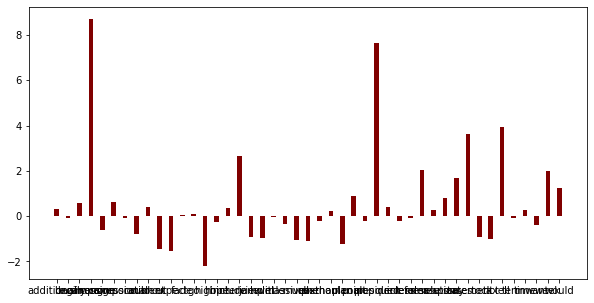

In [152]:
import numpy as np
import matplotlib.pyplot as plt
 
courses = text
values = val
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

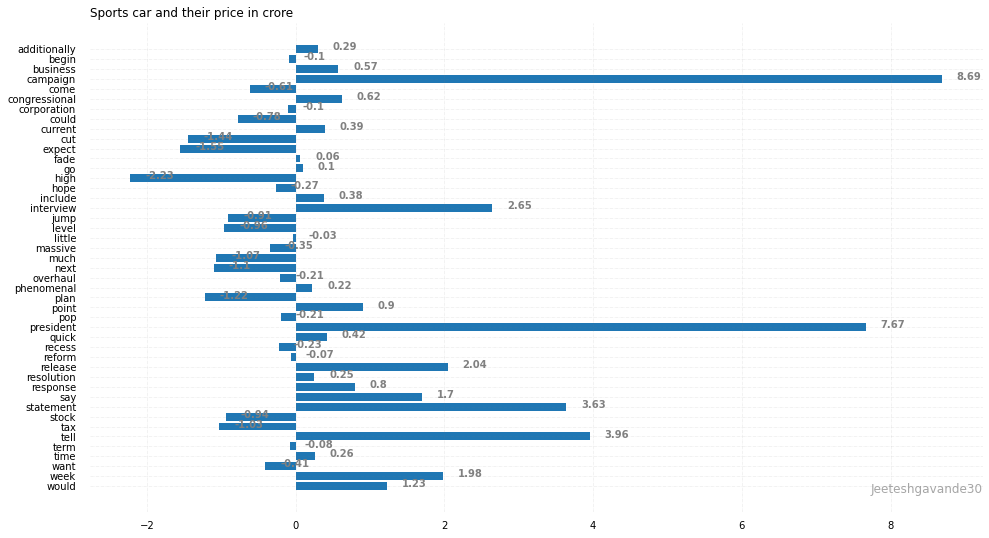

In [156]:
import pandas as pd
from matplotlib import pyplot as plt


name = data['word']
price = data['score']

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(name, price)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 10, fontweight ='bold',
			color ='grey')

# Add Plot Title
ax.set_title('Sports car and their price in crore',
			loc ='left', )

# Add Text watermark
fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
		color ='grey', ha ='right', va ='bottom',
		alpha = 0.7)

# Show Plot
plt.show()


In [106]:
# import pandas as pd
# df =pd.DataFrame(columns=[])
# for key, value in g:
#   print(key, value)
#   break

say 19379


In [85]:
x=torch.tensor([2],requires_grad=True, dtype=torch.float64).to(device)
print(x.requires_grad)
y=x*x
y.backward()
print(x.grad)

True
None


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  """
